In [831]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
import json
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime as dt
import glob

In [791]:
dfs=[]
for file in glob.glob("data/*.json"):
    dataframe = pd.read_json(file)['posts']
    # flatten the structure
    dataframe = pd.json_normalize(dataframe)
    # insert file names
    dataframe['file_name'] = os.path.basename(file)
    dfs.append(dataframe)

# concatenate all data and drop repeated entries
df=pd.concat(dfs).drop_duplicates(subset='uuid', keep='last')

In [792]:
selected_columns = [
    'file_name',
    'uuid', 
    'title',
    'content',
    'post_flair_text',
    'author',
    'author_flair_text',
    'created',
    'comments',
    'score_up',
    'preview',
    'link',
    'domain',
    'is_image',
    'is_video',
    'video_link'
    ]	

df = df[selected_columns]
# replace empty cell with Nan
dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)

# format datetime
df['created'] = pd.to_datetime(df.created, unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
# crate a column storing "date" 
df['created_date'] = df['created'].dt.date
df['created_date'] = df['created_date'].astype(str)



df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 777 entries, 0 to 24
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype                     
---  ------             --------------  -----                     
 0   file_name          777 non-null    object                    
 1   uuid               777 non-null    object                    
 2   title              777 non-null    object                    
 3   content            777 non-null    object                    
 4   post_flair_text    777 non-null    object                    
 5   author             777 non-null    object                    
 6   author_flair_text  777 non-null    object                    
 7   created            777 non-null    datetime64[ns, US/Eastern]
 8   comments           777 non-null    int64                     
 9   score_up           777 non-null    int64                     
 10  preview            777 non-null    object                    
 11  link               777 no

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_5338/44779822.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)


In [793]:
df.created_date.value_counts().sort_index()

created_date
2024-07-21     62
2024-07-22    576
2024-07-23    139
Name: count, dtype: int64

In [794]:
import spacy
from nltk import bigrams, trigrams
nlp = spacy.load('en_core_web_lg')
stopwords = list(nlp.Defaults.stop_words)

# remove additional stopwords, such as Trump
# stopwords.append('trump')

import contractions
import emoji
import re
from tqdm import tqdm
tqdm.pandas()


def clean_it_all_up (text):
    text = emoji.replace_emoji(text)
    text = contractions.fix(text)
    text = re.sub(r'\W+', ' ', text)
    doc = nlp(text)
    lemmatized_tokens = []
    
    for token in doc:
        if (
            token.text.lower() not in stopwords
            and token.pos_ in {'NOUN', 'PROPN'} 
            and token.ent_type_ not in {'GPE', 'LOC'}
        ):
          
            
            lemmatized_tokens.append(token.lemma_.lower())
            
    return " ".join(lemmatized_tokens)   

In [807]:
def date_selection(start_date, end_date):
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    date_list = []
    current_date = start_date
    date_list.append(current_date.strftime('%Y-%m-%d'))

    while current_date < end_date:
        next_date = current_date + datetime.timedelta(days=1)
        next_date = next_date
        if next_date >= end_date:
            next_date = end_date
        date_list.append(next_date.strftime('%Y-%m-%d'))
        current_date = next_date

    return date_list


In [819]:
start_date = '2024-07-21'
end_date =  '2024-07-21'

date_list = date_selection(start_date, end_date)
date_list

['2024-07-21']

In [810]:
df[df.created_date.isin(date_list)].created_date.value_counts()

created_date
2024-07-22    576
2024-07-21     62
Name: count, dtype: int64

In [812]:
def ngram_generator(num, start_date, end_date):
    
    date_list = date_selection(start_date, end_date)

    cleaned_tokens = ' '.join(df[df.created_date.isin(date_list)]['title'].progress_apply(clean_it_all_up).tolist())
    if num == 1:
        ngram = pd.Series(cleaned_tokens.split()).value_counts()
    elif num == 2:
        ngram = pd.Series(list(bigrams(cleaned_tokens.split()))).value_counts()
    elif num == 3:
        ngram = pd.Series(list(trigrams(cleaned_tokens.split()))).value_counts()
    else:
        raise ValueError('Invalid number. Must choose between 1, 2, or 3.')
    
    ngram = ngram[ngram > 1]
    return ngram


In [813]:
ngram_generator(2, '2024-07-22', '2024-07-23')

100%|██████████| 715/715 [00:03<00:00, 208.81it/s]


(joe, biden)                46
(secret, service)           45
(kamala, harris)            43
(service, director)         26
(assassination, attempt)    14
                            ..
(trump, coup)                2
(kamala, life)               2
(tim, pool)                  2
(sh, t)                      2
(mr, beast)                  2
Name: count, Length: 297, dtype: int64

In [843]:
ngram_generator(3, '2024-07-23', '2024-07-23')

100%|██████████| 139/139 [00:00<00:00, 199.65it/s]


(secret, service, director)         5
(elon, musk, trump)                 2
(gang, r, ped)                      2
(appearance, moulin, rouge)         2
(man, appearance, moulin)           2
(police, man, appearance)           2
(woman, police, man)                2
(man, day, olympics)                2
(group, man, day)                   2
(ped, group, man)                   2
(r, ped, group)                     2
(moulin, rouge, saturday)           2
(lyin, kamala, harris)              2
(harris, presidential, campaign)    2
(kamala, harris, presidential)      2
(border, czar, border)              2
Name: count, dtype: int64

In [820]:
from wordcloud import WordCloud

def ngram_cloud(num, start_date, end_date, top_n=None):
    ngram = ngram_generator(num, start_date, end_date)
    ngram = ngram.head(top_n)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

100%|██████████| 62/62 [00:00<00:00, 252.14it/s]


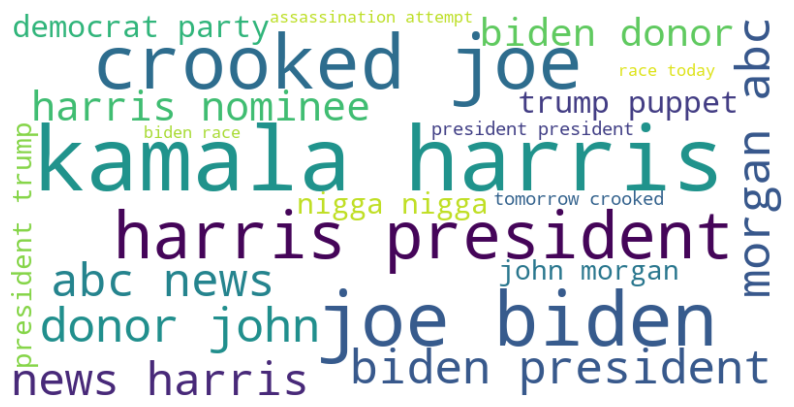

In [822]:
ngram_cloud(2, start_date= "2024-07-21", end_date= "2024-07-21")

100%|██████████| 139/139 [00:00<00:00, 239.60it/s]


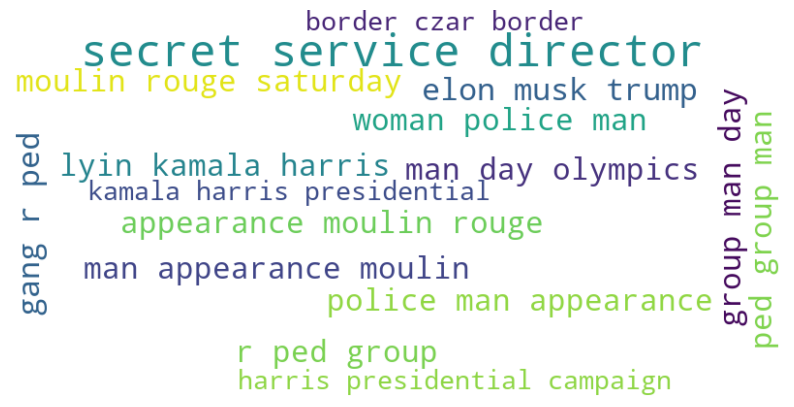

In [835]:
ngram_cloud(3, start_date= "2024-07-23", end_date= "2024-07-23")

In [848]:
# A summary table of authors based on a given date
def top_acounts(start_date, end_date):
    date_list = date_selection(start_date, end_date)
    top_authors = df[df['created_date'].isin(date_list)]['author'].value_counts().reset_index()
    top_authors = top_authors[top_authors['count']>1]
    comments_total = df.groupby('author').comments.sum()
    upvotes_total = df.groupby('author').score_up.sum()
    top_authors =  top_authors.merge(comments_total, on='author').merge(upvotes_total, on='author')
    top_authors = top_authors.rename(columns={'author': 'top_authors',
                                      'count': 'top_articles',
                                      'comments': 'accumulated_comments',
                                      'score_up': 'accumulated_upvotes'
                                      })
    top_authors = top_authors.sort_values('top_articles', ascending=False)
    return  top_authors

In [849]:
start_date = "2024-07-22"
end_date = "2024-07-23"

top_authors = top_acounts(start_date,end_date)
top_authors.head(10)

,top_authors,top_articles,accumulated_comments,accumulated_upvotes
0,I-am-Orlando,31,1070,19959
1,PiratePatriotParrot,30,910,12025
2,rdvs34283,23,299,6315
3,kinbergfan,22,155,7477
4,davidac1982,22,204,7480
5,Trump_Is_My_Daddy,17,371,9656
6,DeusVult1096,13,145,4274
7,KuzoKevin,12,248,6171
8,AlbertSnow,11,360,4659
9,forth2win,11,112,2755


In [847]:
df.domain.value_counts(normalize=True, dropna=False).head(10)

domain
twitter.com                 0.369369
media.scored.co             0.276705
media.patriots.win          0.189189
                            0.063063
www.thegatewaypundit.com    0.014157
thefederalist.com           0.010296
rumble.com                  0.009009
nypost.com                  0.009009
cdn.videy.co                0.005148
www.youtube.com             0.003861
Name: proportion, dtype: float64

In [665]:
# Popular Twitter accounts on The Ronald
date='2024-07-22'

df[(df.link.str.contains('twitter.com') )& (df.created_date== date)]['link'].str.split('/').str[3].value_counts(normalize=False, dropna=False)

link
bennyjohnson      5
EndWokeness       4
catturd2          4
LauraLoomer       3
RealJamesWoods    3
                 ..
RyanAFournier     1
kylenabecker      1
OliLondonTV       1
RepNancyMace      1
StephenM          1
Name: count, Length: 75, dtype: int64